In [437]:
# In The Name of God
# Train Utilizer from obfuscated pictures - 1
# Utilizer Determines Gender, using Dense121 with freezing FE.
# this model will train on obfuscated data as an utilizer
# the of accuracy in this term means Utility.
# changes:
#      V1:   25/12/1400 - base
#      V2:   26/12/1400 - model updated!
#      V2-1  15/09/1401 - learn on unobfuscated dataset for 100 epoch
#      V3:   17/09/1401 - ready for train on ubfuscated datasets added adversary for inferring accuracy on obfuscated data

In [438]:
#@title
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from collections import OrderedDict
import time

from torch.utils.data import random_split
from math import floor

import torchvision.utils as vutils
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import itertools
import random

import shutil
from zipfile import ZipFile
import os

from IPython.core.debugger import set_trace

In [439]:
# Hyper parameters:
# change lastRunEpochNumber for every run based on saved files
isFirstRun = True
lastRunEpochNumber = 0
manual_seed = 20
image_size = 64
use_whole_dataset = False
usage_percent = 0.5
celeba_male_index = 20
celeba_young_index = 39
celeba_smiling_index = 31
celeba_straight_hair_index = 32
celeba_wavy_hair_index = 33
celeba_black_hair_index = 8
celeba_blonde_hair_index = 9
celeba_brown_hair_index = 11
celeba_gray_hair_index = 17
celeba_eyeglasses_index = 15
celeba_chubby_index = 13

celeba_mouth_open_index = 21
celeba_high_cheekbone_index = 19

is_adv = False
using_index = celeba_smiling_index
adv_using_index = celeba_male_index
if is_adv:
  using_index = adv_using_index

saving_pic_file_name = "obf_test_pics.png"

is_second_adv = True
if is_second_adv:
  adv_using_index2 = adv_using_index
else:
  adv_using_index2 = using_index

learning_rate = 0.001 #0.001
batch_size = 64

files_not_ready = False
dataset_folder_path = 'drive/MyDrive/ML/datasetShortcuts/CelebA'
#'C:/Workspace/Datasets/CelebA'
#'D:/on going/server/CelebA'
# dataset_folder_path = 'drive/MyDrive/ML/datasetShortcuts/CelebA'
data_dir = 'celeba'
save_dir = 'utl-trn-3-G-S-NLLLoss-test'
saving_path = 'drive/MyDrive/ML/saves/' + save_dir + '/'
#'C:/Users/jamshidi/saveMLs/' + save_dir + '/'
#'C:/Users/Mohammad/savedML/' + save_dir + '/'
# saving_path = 'drive/MyDrive/ML/saves/' + save_dir + '/'

# modified dataset:
copied_and_unzipped_from_drive = False
# is_m_dataset_files_ready = False
load_main_dataset = False
m_version = '-nog-awgn-40'
ref_project = 'p2r-ae-9rev2-G-S' + m_version
on_drive_zipped_file_path = 'drive/MyDrive/ML/modifiedDatasets/' + ref_project + '/celeba.zip'
# 'C:/Users/jamshidi/modifiedDatasets/' + ref_project + '/img_align_celeba.zip'
# 'C:/Users/Mohammad/modifiedDatasets/' + ref_project + '/img_align_celeba.zip'
# 'drive/MyDrive/ML/modifiedDatasets/' + ref_project + '/img_align_celeba.zip'
modified_dataset_saving_path = 'modifiedDatasets/' + save_dir + '/'
#'C:/Users/jamshidi/modifiedDatasets/' + save_dir + '/'
#'C:/Users/Mohammad/modifiedDatasets/' + save_dir + '/'
# 'drive/MyDrive/ML/modifiedDatasets/' + save_dir + '/'

suffling_main_train_data = True
suffling_modified_train_data = True

use_early_stop = False
use_rate_schedule = False

# Adversary
load_adversary = True
if is_second_adv:
  epoch_number_of_adversary_model = 10
  adversary_saving_path = 'drive/MyDrive/ML/saves/adv-trn-2-G-NLLLoss/'
else:
  epoch_number_of_adversary_model = 7
  adversary_saving_path = 'drive/MyDrive/ML/saves/adv-trn-2-S-NLLLoss/'

# Other params
# Number of workers for dataloader
workers = 2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Size of feature maps in encoder
nef = 64
# Size of feature maps in decoder
ndf = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Number of training epochs
num_epochs = 0 #10

In [440]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [441]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [442]:
# drive.flush_and_unmount()

In [443]:
# download dataset and unzip
# data_dir variable: data_dir = 'img_align_celeba'
dataset_zip_path = dataset_folder_path + '/Img/img_align_celeba.zip'
list_eval_partition_path = dataset_folder_path + '/Eval/list_eval_partition.txt'
identity_celeba_path = dataset_folder_path + '/Anno/identity_CelebA.txt'
list_attr_celeba_path = dataset_folder_path + '/Anno/list_attr_celeba.txt'
list_bbox_celeba_path = dataset_folder_path + '/Anno/list_bbox_celeba.txt'
list_landmarks_align_celeba_path = dataset_folder_path + '/Anno/list_landmarks_align_celeba.txt'

if files_not_ready:
    try:
      os.mkdir(data_dir)
      print("data folder created successfully")
    except OSError as e:
      print("Error: %s" % (e.strerror))

    shutil.copyfile(dataset_zip_path, data_dir + r'/img_align_celeba.zip')
    shutil.copyfile(list_eval_partition_path, data_dir + r'/list_eval_partition.txt')
    shutil.copyfile(identity_celeba_path, data_dir + r'/identity_CelebA.txt')
    shutil.copyfile(list_attr_celeba_path, data_dir + r'/list_attr_celeba.txt')
    shutil.copyfile(list_bbox_celeba_path, data_dir + r'/list_bbox_celeba.txt')
    shutil.copyfile(list_landmarks_align_celeba_path, data_dir + r'/list_landmarks_align_celeba.txt')

    try:
        shutil.rmtree(data_dir + r'/img_align_celeba')
        print("old unzipped directory removed successfully")
    except OSError as e:
        print("Error: %s" % (e.strerror))

    archive = data_dir + r'/img_align_celeba.zip'
    with ZipFile(archive, 'r') as zip:
       zip.extractall(data_dir)
try:
    os.mkdir(saving_path)
    print("saving_path directory created successfully")
except OSError as e:
    print("Error: %s" % (e.strerror))

Error: File exists


In [444]:
# copy and unzip from drive to this env:
m_celeba_dir = modified_dataset_saving_path + 'celeba/'
img_celeba_dir = modified_dataset_saving_path + 'celeba/img_align_celeba/'

try:
  os.mkdir('modifiedDatasets')
  print("modified data folder created successfully")
except OSError as e:
  print("Error: one of %s" % (e.strerror))
try:
  os.mkdir(modified_dataset_saving_path)
  print("modified data folder created successfully")
except OSError as e:
  print("Error: one of %s" % (e.strerror))
try:
  os.mkdir(m_celeba_dir)
  print("modified data folder created successfully")
except OSError as e:
  print("Error: one of %s" % (e.strerror))

if not copied_and_unzipped_from_drive:
  shutil.copyfile(on_drive_zipped_file_path, modified_dataset_saving_path + 'celeba.zip')
  archive1 = modified_dataset_saving_path + 'celeba.zip'
  with ZipFile(archive1, 'r') as zip:
      zip.extractall(m_celeba_dir)

Error: one of File exists
Error: one of File exists
Error: one of File exists


In [445]:
class LRScheduler():
    """
    Learning rate scheduler. If the validation loss does not decrease for the
    given number of `patience` epochs, then the learning rate will decrease by
    by given `factor`.
    """
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        """
        new_lr = old_lr * factor
        :param optimizer: the optimizer we are using
        :param patience: how many epochs to wait before updating the lr
        :param min_lr: least lr value to reduce to while updating
        :param factor: factor by which the lr should be updated
        """
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [446]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    def __call__(self, score):
        if self.best_score == None:
            self.best_score = score
        elif self.best_score - score > self.min_delta:
            self.best_score = score
            self.counter = 0
        elif self.best_score - score < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [447]:
# Define transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       #transforms.RandomResizedCrop(224),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(image_size),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [448]:
#@title
# Function - use some percent of data
def shorten_dataset(dataset, usage_percent=1.0):
  len_used = floor(len(dataset)*usage_percent)
  len_not_used = len(dataset) - len_used
  used_dataset, not_used_dataset = random_split(dataset, [len_used, len_not_used], generator=torch.Generator().manual_seed(manual_seed))
  return used_dataset

In [449]:
# Function - Split Data to Public & Private
def split_to_public_private(dataset, usage_percent=1.0, public_percent=0.25):
  len_used = floor(len(dataset)*usage_percent)
  len_not_used = len(dataset) - len_used
  used_dataset, not_used_dataset = random_split(dataset, [len_used, len_not_used], generator=torch.Generator().manual_seed(manual_seed))
  len_public = floor(len(used_dataset)*public_percent)
  len_private = len(used_dataset) - len_public
  return random_split(used_dataset, [len_public, len_private], generator=torch.Generator().manual_seed(manual_seed))


In [450]:
# Load Datas
if load_main_dataset:
    train_set = datasets.CelebA(root='', download=False, split='train', target_type=["attr", "identity"], transform=train_transforms)
    test_set = datasets.CelebA(root='', download=False, split='test', target_type=["attr", "identity"], transform=test_transforms)
    valid_set = datasets.CelebA(root='', download=False, split='valid', target_type=["attr", "identity"], transform=test_transforms)

    # shorten Dataset
    if not use_whole_dataset:
      train_set = shorten_dataset(train_set, usage_percent)
      # we do not shorten test and valid sets due to better accuracy evaluating
      # test_set = shorten_dataset(test_set, usage_percent)
      valid_set = shorten_dataset(valid_set, usage_percent)

    # DataLoader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=suffling_main_train_data, num_workers=workers, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=workers, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, num_workers=workers, drop_last=True)


In [451]:
# load modified dataset:
m_transforms = transforms.Compose([
                                  #transforms.Resize(image_size),
                                  #transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                  ])
m_train_set = datasets.CelebA(root=modified_dataset_saving_path, download=False, split='train', target_type=["attr", "identity"], transform=m_transforms)
m_valid_set = datasets.CelebA(root=modified_dataset_saving_path, download=False, split='valid', target_type=["attr", "identity"], transform=m_transforms)
m_test_set = datasets.CelebA(root=modified_dataset_saving_path, download=False, split='test', target_type=["attr", "identity"], transform=m_transforms)

# shorten Dataset
if not use_whole_dataset:
  m_train_set = shorten_dataset(m_train_set, usage_percent)
  # we do not shorten test and valid sets due to better accuracy evaluating
  # m_test_set = shorten_dataset(m_test_set, usage_percent)
  m_valid_set = shorten_dataset(m_valid_set, usage_percent)

m_train_loader = torch.utils.data.DataLoader(m_train_set, batch_size=batch_size, shuffle=suffling_modified_train_data, num_workers=workers, drop_last=True)
m_valid_loader = torch.utils.data.DataLoader(m_valid_set, batch_size=batch_size, num_workers=workers, drop_last=True)
m_test_loader = torch.utils.data.DataLoader(m_test_set, batch_size=batch_size, num_workers=workers, drop_last=True)

In [452]:
# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [453]:
# Plot some training images
# real_batch = next(iter(train_loader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [454]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [455]:
# Utilizer Model - infer identity (just for usage_percent = 1.0) - or - infer sex (male/female) - or infer age (young/old)
# Genser is selected. (male = 1)

# def UtlModel(pretrained=True, requires_grad=False):
#     model = models.densenet121(progress=True, pretrained=pretrained)
#     # either freeze or train the hidden layer parameters
#     if requires_grad == False:
#         for param in model.parameters():
#             param.requires_grad = False
#     elif requires_grad == True:
#         for param in model.parameters():
#             param.requires_grad = True
#     # make the classification layer learnable
#     utilizerClassifier = nn.Sequential(OrderedDict([
#                           ('fc1', nn.Linear(1024, 500)),
#                           ('relu', nn.ReLU()),
#                           ('fc2', nn.Linear(500, 2)),
#                           ('output', nn.LogSoftmax(dim=1))
#                           ]))

#     model.classifier = utilizerClassifier
#     return model

In [456]:
# Utilizer Model
class UtlModel(nn.Module):
    def __init__(self, ngpu):
        super(UtlModel, self).__init__()
        self.ngpu = ngpu

        # input is nc x 64 x 64
        self.conv1 = nn.Conv2d(nc, nef, 4, 2, 1, bias=False)
        self.actv1 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 32 x 32
        self.conv2 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor2 = nn.BatchNorm2d(nef)
        self.actv2 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 16 x 16
        self.conv3 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor3 = nn.BatchNorm2d(nef)
        self.actv3 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 8 x 8
        self.conv4 = nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False)
        self.bnor4 = nn.BatchNorm2d(nef * 2)
        self.actv4 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef*2) x 4 x 4
        # shaping would be here: nef*2 x 4 x 4 -> 2048
        # state size. 2048
        self.fllc5 = nn.Linear(nef*2*4*4, nef*1*4*4)
        self.actv5 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 1024

        # classifier: 
        self.fllc_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features1 = nn.Dropout(p=0.5)
        self.fllc_features2 = nn.Linear(nef*1*4*4, nef*4)
        self.actv_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features2 = nn.Dropout(p=0.5)
        self.fllc_features3 = nn.Linear(nef*4, nef)
        self.actv_features3 = nn.LeakyReLU(0.2, inplace=True)
        self.fllc_features4 = nn.Linear(nef, 2)
        self.actv_features4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Part 1:
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.conv2(x)
        x = self.bnor2(x)
        x = self.actv2(x)
        x = self.conv3(x)
        x = self.bnor3(x)
        x = self.actv3(x)
        x = self.conv4(x)
        x = self.bnor4(x)
        x = self.actv4(x)
        # flatten
        x = torch.flatten(x, start_dim = 1)
        # Part 2:
        x = self.fllc5(x)
        x = self.actv5(x)
        # classifier:
        y1 = self.fllc_features1(x)
        y1 = self.actv_features1(y1)
        y1 = self.dropout_features1(y1)
        y1 = self.fllc_features2(y1)
        y1 = self.actv_features2(y1)
        y1 = self.dropout_features2(y1)
        y1 = self.fllc_features3(y1)
        y1 = self.actv_features3(y1)
        y1 = self.fllc_features4(y1)
        y1 = self.actv_features4(y1)
        return y1


In [457]:
# Create the UTL
utilizerModel = UtlModel(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    utilizerModel = nn.DataParallel(utilizerModel, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
utilizerModel.apply(weights_init)

UtlModel(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (actv1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnor2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnor3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnor4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv4): LeakyReLU(negative_slope=0.2, inplace=True)
  (fllc5): Linear(in_features=2048, out_features=1024, bias=True)
  (actv5): LeakyReLU(negative_slope=0.2, inplace=True)
  (fllc_features1):

In [458]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in utilizerModel.parameters())
print(f"{total_params:,} training parameters.")

3,692,482 training parameters.


In [459]:
utilizerCriterion = nn.NLLLoss() # nn.MSELoss()
utilizerOptimizer = optim.Adam(utilizerModel.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [460]:
# Function - Save:
def save_model(name, number, model, res):
  checkpoint = {'res': res,
                'state_dict': model.state_dict()}
  torch.save(checkpoint, saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth')
  return True

In [461]:
# Function - Load:
def load_model(name, number, model, device):

  checkpoint = torch.load(saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth', map_location=device)
  res = checkpoint['res']
  model.load_state_dict(checkpoint['state_dict'])
  return {'model':model,
          'res':res}

In [462]:
# Function - Delete file:
def delete_file(name, number):
  address = saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth'
  try:
    os.remove(address)
    print("old file removed successfully")
  except OSError as e:
    print("Error: %s" % (e.strerror))

In [463]:
# Save Start Checkpoint

if(isFirstRun):
  utl_res = {'train_losses': [],
             'valid_losses': [],
             'test_y1_acc': [],
             'epoch_number': 0,
           };
  save_model('utl', 0, utilizerModel, utl_res)

In [464]:
# Load Last Checkpoint:
utl_load = load_model('utl', lastRunEpochNumber, utilizerModel, device)

train_losses = utl_load['res']['train_losses']
valid_losses = utl_load['res']['valid_losses']
test_y1_acc = utl_load['res']['test_y1_acc']
last_epoch = utl_load['res']['epoch_number']

In [465]:
# either early stopping or learning rate scheduler
if use_rate_schedule:
    print('INFO: Learning rate scheduler is on')
    lr_scheduler = LRScheduler(utilizerOptimizer)

if use_early_stop:
    print('INFO: Early stopping is on')
    early_stopping = EarlyStopping()


In [466]:
def fix_getting_data_problem(labels, decision_label):
    if use_whole_dataset:
        # return labels[0][:, 0, decision_label]
        return labels[0][:, decision_label]
    else:
        return labels[0][:, decision_label]

In [467]:
def extract_targets(labels):
    male_labels = fix_getting_data_problem(labels, using_index)
    female_labels = torch.add(1, -male_labels)
    # HERE! there were a bug. we should concat(female,male) not concat(male,female)
    # male_target = torch.cat((male_labels.view(batch_size,1), female_labels.view(batch_size,1)), 1).float() # 64 is batch_size
    male_target = torch.cat((female_labels.view(batch_size,1), male_labels.view(batch_size,1)), 1).float() # 64 is batch_size
    male_target = male_target.to(device)
    return male_target

In [468]:
# Function - training function
def fit(model, train_loader, optimizer, criterion):
    print('Training')
    model.train()

    train_loss = 0.0
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, data in prog_bar:
        inputs, labels = data[0], data[1]
        inputs = inputs.to(device)
        # male_target = extract_targets(labels)
        male_target = labels[0][:, using_index]
        male_target = male_target.to(device)
        model.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, male_target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    return train_loss

In [469]:
# Function - validation function
def validate(model, valid_loader, criterion):
    print('Validating')
    model.eval()
    valid_loss = 0.0

    prog_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[1]
            inputs = inputs.to(device)
            # male_target = extract_targets(labels)
            male_target = labels[0][:, using_index]
            male_target = male_target.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, male_target)
            valid_loss += loss.item()
        valid_loss = valid_loss / len(valid_loader)
        return valid_loss

In [470]:
# Calc Accuracy
def calcAccuracyTest(model, test_loader):
    print('Testing')
    model.to(device)
    print("Calculating Accuracy...")
    model.eval()
    y1_accuracy = 0
    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[1]
            inputs = inputs.to(device)
            # male_target = extract_targets(labels)
            male_target = labels[0][:, using_index]
            male_target = male_target.to(device)
            # a1, male_label_top_class = male_target.topk(1, dim=1)
            output = model(inputs)
            ps_y1 = torch.exp(output)
            top_p_y1, top_class_y1 = ps_y1.topk(1, dim=1)
            # equals_y1 = top_class_y1 == male_label_top_class.view(*top_class_y1.shape)
            equals_y1 = top_class_y1 == male_target.view(*top_class_y1.shape)
            acc_y1 = equals_y1.sum().item()
            y1_accuracy += (acc_y1 / len(equals_y1))
    y1_accuracy = y1_accuracy / len(test_loader)
    return y1_accuracy

In [471]:
# Training Loop
utilizerModel.to(device)
calc_every_epoch = 1
save_every_epoch = 1

if is_adv:
  here_test_loader = m_test_loader
else:
  here_test_loader = test_loader

start = time.time()
print("Starting Training Loop...")

for epoch in range(last_epoch+1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}: ")

    train_loss = fit(utilizerModel, m_train_loader, utilizerOptimizer, utilizerCriterion)
    valid_loss = validate(utilizerModel, m_valid_loader, utilizerCriterion)
    y1_accuracy = calcAccuracyTest(utilizerModel, here_test_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_y1_acc.append(y1_accuracy)

    utl_res = {'train_losses': train_losses,
               'valid_losses': valid_losses,
               'test_y1_acc': test_y1_acc,
               'epoch_number': epoch
                }
    save_model('utl', 'last', utilizerModel, utl_res)
    if epoch % save_every_epoch == 0:
      # if epoch-save_every_epoch>=0:
      #   delete_file('utl', epoch-save_every_epoch)
      save_model('utl', epoch, utilizerModel, utl_res)

    if use_rate_schedule:
        lr_scheduler(valid_loss)
    if use_early_stop:
        early_stopping(valid_loss)
        if early_stopping.early_stop:
            break

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}")
    print(f"Male Accuracy on unobfuscated Testset: {y1_accuracy:.4f}")

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

print('TRAINING COMPLETE')

Starting Training Loop...
Training time: 0.000 minutes
TRAINING COMPLETE


Loss plot...


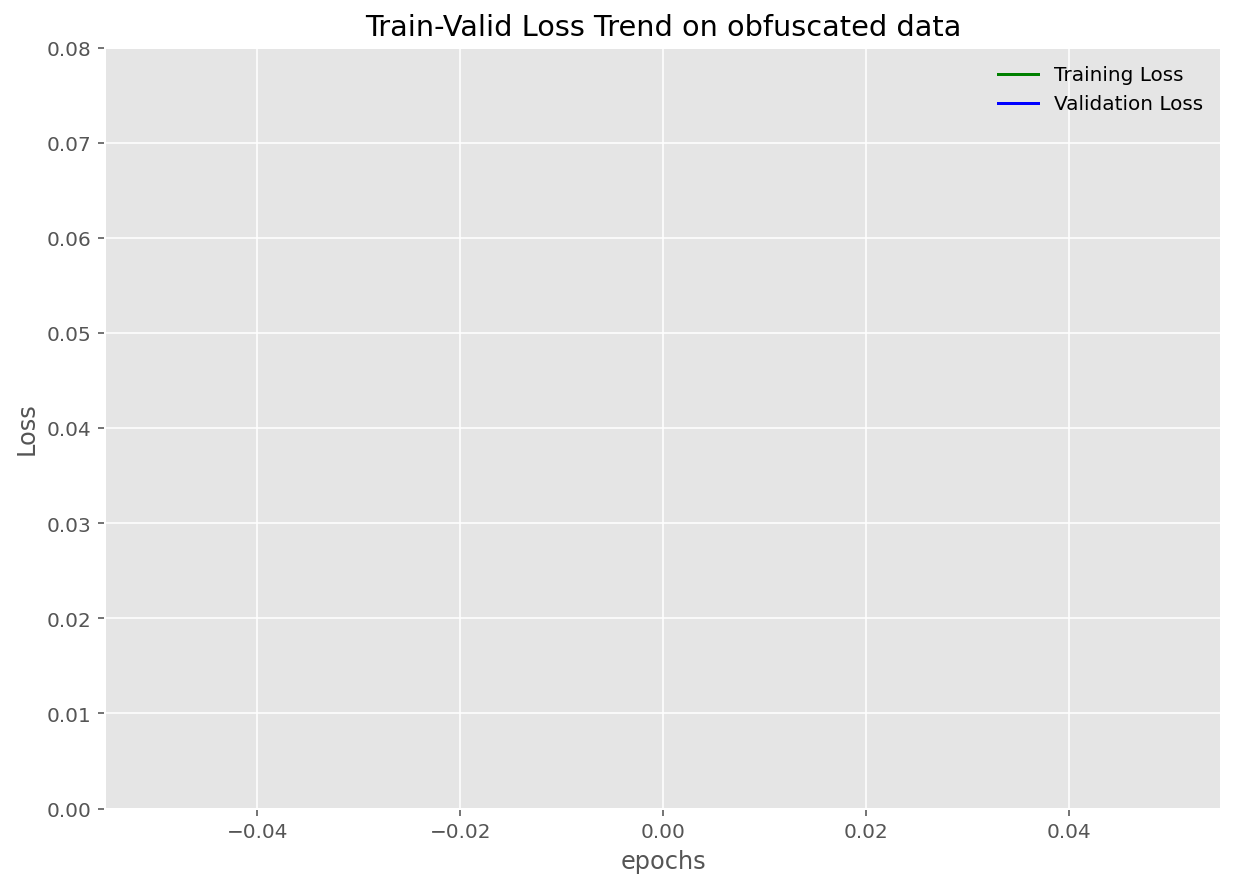

In [472]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('Loss plot...')

# loss plots
plt.figure(figsize=(10,7))
plt.title("Train-Valid Loss Trend on obfuscated data")
plt.plot(train_losses, color='green', label='Training Loss')
plt.plot(valid_losses, color='blue', label='Validation Loss')
plt.ylim([0,0.08])
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.savefig(saving_path + "loss_plot.png")
plt.show()

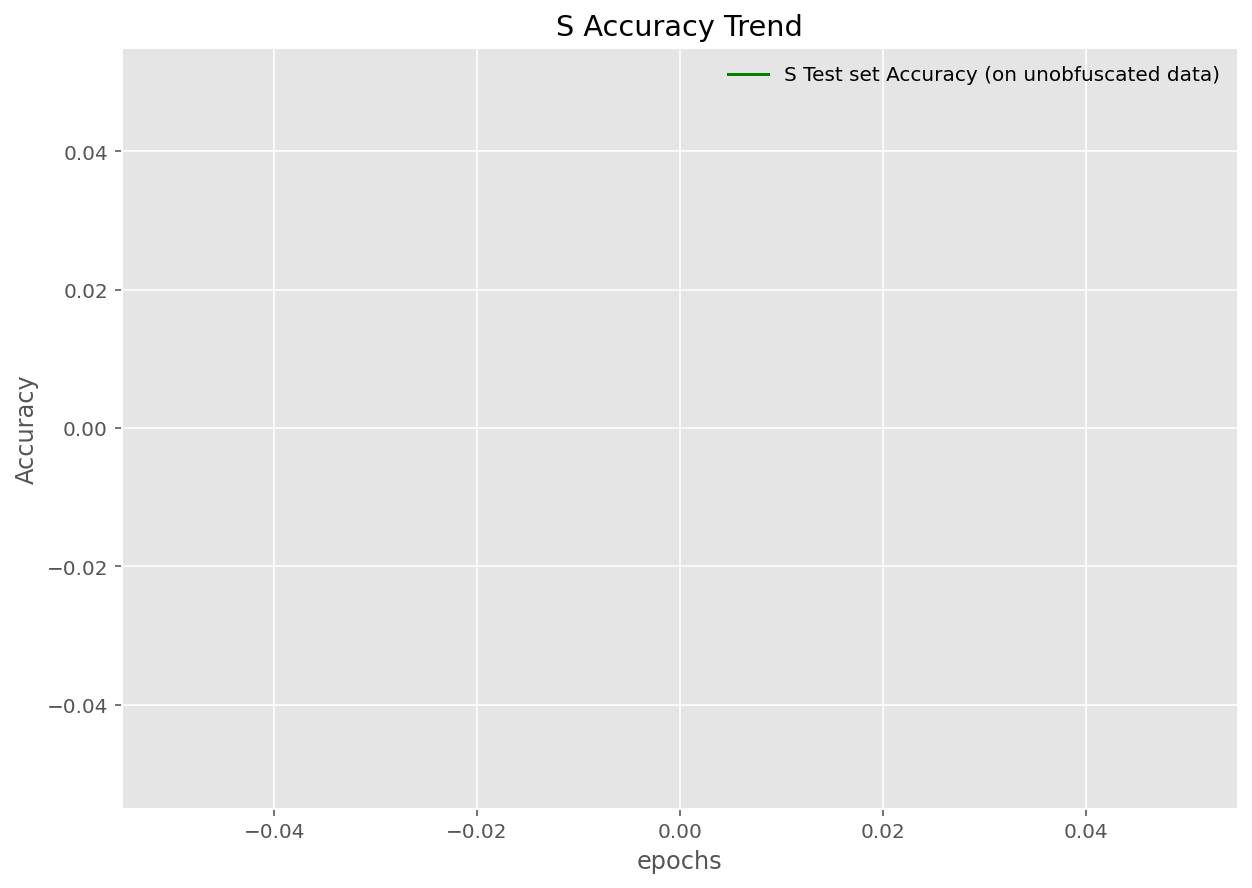

In [473]:
plt.figure(figsize=(10,7))
plt.title("S Accuracy Trend")
plt.plot(test_y1_acc, color='green', label='S Test set Accuracy (on unobfuscated data)')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.savefig(saving_path + "accuracy_test_plot.png")
plt.show()

In [474]:
# For Adversary
# Adversary Model - infer identity (just for usage_percent = 1.0) - or - infer sex (male/female) - or infer age (young/old)
# Age is selected. (young = 1)
class AdvModel(nn.Module):
    def __init__(self, ngpu):
        super(AdvModel, self).__init__()
        self.ngpu = ngpu
        
        # input is nc x 64 x 64 
        self.conv1 = nn.Conv2d(nc, nef, 4, 2, 1, bias=False)
        self.actv1 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 32 x 32
        self.conv2 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor2 = nn.BatchNorm2d(nef)
        self.actv2 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 16 x 16
        self.conv3 = nn.Conv2d(nef, nef, 4, 2, 1, bias=False)
        self.bnor3 = nn.BatchNorm2d(nef)
        self.actv3 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef) x 8 x 8
        self.conv4 = nn.Conv2d(nef, nef * 2, 4, 2, 1, bias=False)
        self.bnor4 = nn.BatchNorm2d(nef * 2)
        self.actv4 = nn.LeakyReLU(0.2, inplace=True)
        # state size. (nef*2) x 4 x 4
        # shaping would be here: nef*2 x 4 x 4 -> 2048
        # state size. 2048
        self.fllc5 = nn.Linear(nef*2*4*4, nef*1*4*4)
        self.actv5 = nn.LeakyReLU(0.2, inplace=True)
        # state size. 1024

        # classifier: (age)
        self.fllc_features1 = nn.Linear(nef*1*4*4, nef*1*4*4)
        self.actv_features1 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features1 = nn.Dropout(p=0.5)
        self.fllc_features2 = nn.Linear(nef*1*4*4, nef*4)
        self.actv_features2 = nn.LeakyReLU(0.2, inplace=True)
        self.dropout_features2 = nn.Dropout(p=0.5)
        self.fllc_features3 = nn.Linear(nef*4, nef)
        self.actv_features3 = nn.LeakyReLU(0.2, inplace=True)
        self.fllc_features4 = nn.Linear(nef, 2)
        self.actv_features4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Part 1:
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.conv2(x)
        x = self.bnor2(x)
        x = self.actv2(x)
        x = self.conv3(x)
        x = self.bnor3(x)
        x = self.actv3(x)
        x = self.conv4(x)
        x = self.bnor4(x)
        x = self.actv4(x)
        # flatten
        x = torch.flatten(x, start_dim = 1)
        # Part 2:
        x = self.fllc5(x)
        x = self.actv5(x)
        # classifier: (age)
        y1 = self.fllc_features1(x)
        y1 = self.actv_features1(y1)
        y1 = self.dropout_features1(y1)
        y1 = self.fllc_features2(y1)
        y1 = self.actv_features2(y1)
        y1 = self.dropout_features2(y1)
        y1 = self.fllc_features3(y1)
        y1 = self.actv_features3(y1)
        y1 = self.fllc_features4(y1)
        y1 = self.actv_features4(y1)
        return y1


In [475]:
# For Adversary
def adv_load_model(name, number, model, device):
  
  checkpoint = torch.load(adversary_saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth', map_location=device)
  res = checkpoint['res']
  model.load_state_dict(checkpoint['state_dict'])
  return {'model':model,
          'res':res}

In [476]:
# For Adversary
# Create the ADV
adversaryModel = AdvModel(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    adversaryModel = nn.DataParallel(adversaryModel, list(range(ngpu)))

adv_load = adv_load_model('adv', epoch_number_of_adversary_model, adversaryModel, device)

In [477]:
# For Adversary
def extract_adv_targets(labels):
    young_labels = fix_getting_data_problem(labels, adv_using_index2)
    old_labels = torch.add(1, -young_labels)
    young_target = torch.cat((young_labels.view(64,1), old_labels.view(64,1)), 1).float() # 64 is batch_size
    young_target = young_target.to(device)
    return young_target

In [478]:
# For Adversary
# Calc Accuracy
def calcAdvAccuracyTest(model, test_loader):
    print('Testing')
    model.to(device)
    print("Calculating Accuracy...")
    model.eval()
    y1_accuracy = 0
    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[1]
            inputs = inputs.to(device)
            # young_target = extract_adv_targets(labels)
            young_target = labels[0][:, adv_using_index2]
            young_target = young_target.to(device)
            # a1, young_label_top_class = young_target.topk(1, dim=1)
            output = model(inputs)
            ps_y1 = torch.exp(output)
            top_p_y1, top_class_y1 = ps_y1.topk(1, dim=1)
            # equals_y1 = top_class_y1 == young_label_top_class.view(*top_class_y1.shape)
            equals_y1 = top_class_y1 == young_target.view(*top_class_y1.shape)
            acc_y1 = equals_y1.sum().item()
            y1_accuracy += (acc_y1 / len(equals_y1))            
    y1_accuracy = y1_accuracy / len(test_loader)
    return y1_accuracy

In [479]:
# For Adversary
if load_adversary:
  # Test on obfuscated data
  adversaryModel.to(device)
  young_accuracy = calcAdvAccuracyTest(adversaryModel, m_test_loader)
  print(f"\n Adversary Gender Accuracy on Testset: {young_accuracy:.3f}")

Testing
Calculating Accuracy...


100%|██████████| 311/311 [00:41<00:00,  7.52it/s]


 Adversary Gender Accuracy on Testset: 0.523


In [480]:
young_accuracy

0.5228597266881029

In [481]:
import operator
indexed = list(enumerate(test_y1_acc))
top_30 = sorted(indexed, key=operator.itemgetter(1))[-30:]
print(list(reversed([i for i, v in top_30])))
print(list(reversed([v for i, v in top_30])))

[]
[]


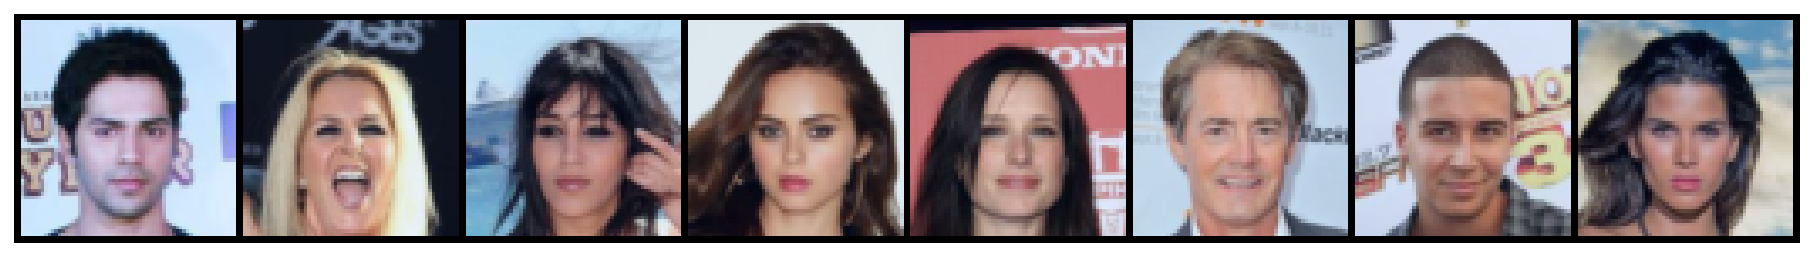

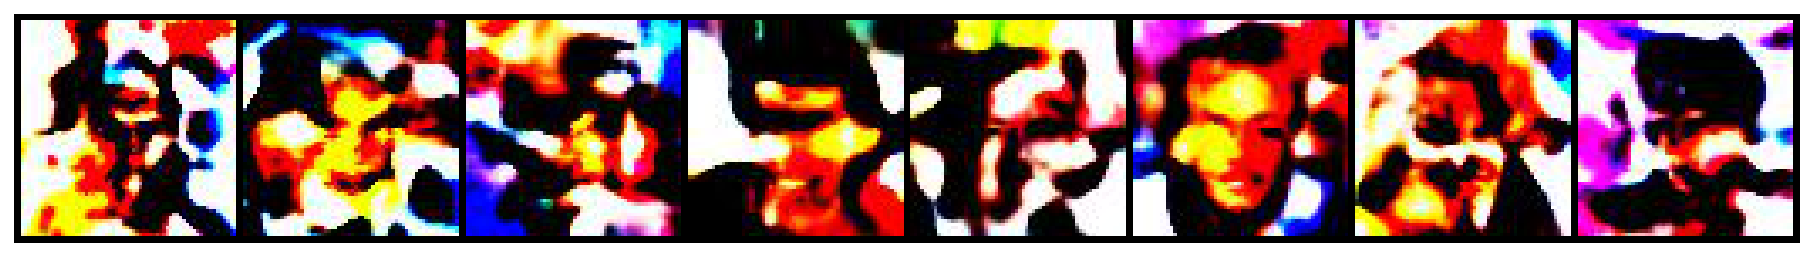

In [482]:
first_batch1 = next(iter(test_loader))
first_batch2 = next(iter(m_test_loader))

first_batch1[0][0] = first_batch1[0][5]
first_batch1[0][1] = first_batch1[0][16]
first_batch1[0][2] = first_batch1[0][18]
first_batch1[0][3] = first_batch1[0][21]
first_batch1[0][4] = first_batch1[0][29]
first_batch1[0][5] = first_batch1[0][43]
first_batch1[0][6] = first_batch1[0][44]
first_batch1[0][7] = first_batch1[0][54]

first_batch2[0][0] = first_batch2[0][5]
first_batch2[0][1] = first_batch2[0][16]
first_batch2[0][2] = first_batch2[0][18]
first_batch2[0][3] = first_batch2[0][21]
first_batch2[0][4] = first_batch2[0][29]
first_batch2[0][5] = first_batch2[0][43]
first_batch2[0][6] = first_batch2[0][44]
first_batch2[0][7] = first_batch2[0][54]

plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(first_batch1[0][0:8].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# plt.savefig(saving_path + "main_pics.png")
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(first_batch2[0][0:8].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
if not is_adv:
  plt.savefig(saving_path + saving_pic_file_name)